<a href="https://colab.research.google.com/github/siwar-lachiheb/versioncnn1/blob/main/pneumoniaCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing packages

In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

Naming project

In [3]:
project_name='normal-vs-pneumonia-cnn'

Downloading Dataset


In [4]:
#installation du package kaggle
!pip install -q kaggle 
#Création d'un dossier kaggle
!mkdir ~/.kaggle/
#Copier kaggle.json dans le dossier Kaggle
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/
#donner les droits à kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
#télécharger le dataset
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#unzip dataset and move it to drive to avoid it being deleted
! unzip /content/chest-xray-pneumonia.zip -d pneumonia_data

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/chest-xray-pneumonia.zip
replace pneumonia_data/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
#resizing images
import PIL
import os
from PIL import Image
directories=['/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/test/NORMAL','/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/test/PNEUMONIA',
             '/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/train/NORMAL','/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/train/PNEUMONIA']
for d in directories:
  for file in os.listdir(d):
    d_img = d+"/"+file
    img = Image.open(d_img)
    img = img.resize((64,64))
    img.save(d_img)

In [6]:
data_dir = '/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['NORMAL', 'PNEUMONIA']


In [7]:
"""pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for pneumonia cases:', len(pneumonia_files))
print(pneumonia_files[:5])"""

'pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")\nprint(\'No. of training examples for pneumonia cases:\', len(pneumonia_files))\nprint(pneumonia_files[:5])'

In [8]:
"""normal_train_files = os.listdir(data_dir + "/train/NORMAL")
print("No. of test examples for normal cases:", len(normal_train_files))
print(normal_train_files[:5])"""

'normal_train_files = os.listdir(data_dir + "/train/NORMAL")\nprint("No. of test examples for normal cases:", len(normal_train_files))\nprint(normal_train_files[:5])'

In [9]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [10]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [11]:
#img, label = dataset[0]
#print(img.shape, label)
#img

In [12]:
#print(dataset.classes)

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [14]:
import cv2 as cv
def Denoising (img):
    return cv.fastNlMeansDenoising(img,None,3,7,21)


In [15]:

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [16]:
"""!pip install jovian --upgrade -q
import jovian
jovian.commit(project=project_name)"""

'!pip install jovian --upgrade -q\nimport jovian\njovian.commit(project=project_name)'

In [17]:
#test_ds,train_ds, val_ds = '/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/test','/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/train','/content/drive/MyDrive/Kaggle/pneumonia_data/chest_xray/chest_xray/val'


In [18]:
random_seed = 42
torch.manual_seed(random_seed);

In [19]:
val_size = len(dataset)//10
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(4695, 521)

In [20]:
from torch.utils.data.dataloader import DataLoader

batch_size=10

In [21]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [23]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [26]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([10, 3, 64, 64])
out.shape: torch.Size([10, 8, 32, 32])


Traceback (most recent call last):


defining the model by extending an** ImageClassificationBase **class which contains helper methods for training & validation.

In [27]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [28]:
class PneumoniaCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 8 x 8

            nn.Flatten(), 
            nn.Linear(512*8*8, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [29]:
model = PneumoniaCNN()
model

PneumoniaCNN(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=32768, out_features=2048, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [30]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([10, 3, 64, 64])
out.shape: torch.Size([10, 2])
out[0]: tensor([ 0.0175, -0.0164], grad_fn=<SelectBackward0>)


In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

defining two functions: **fit** and **evaluate** to train the model using **gradient descent** and evaluate its performance on the validation set

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
model = to_device(PneumoniaCNN(), device)

In [38]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.27037036418914795, 'val_loss': 0.6954925656318665}

In [39]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [40]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.5334, val_loss: 0.5387, val_acc: 0.7870
Epoch [1], train_loss: 0.2902, val_loss: 0.1110, val_acc: 0.9593
Epoch [2], train_loss: 0.1649, val_loss: 0.0743, val_acc: 0.9685
Epoch [3], train_loss: 0.1305, val_loss: 0.0872, val_acc: 0.9722
Epoch [4], train_loss: 0.1221, val_loss: 0.1043, val_acc: 0.9611
Epoch [5], train_loss: 0.1063, val_loss: 0.0609, val_acc: 0.9722
Epoch [6], train_loss: 0.1524, val_loss: 0.1301, val_acc: 0.9611
Epoch [7], train_loss: 0.1107, val_loss: 0.0677, val_acc: 0.9722
Epoch [8], train_loss: 0.0828, val_loss: 0.0616, val_acc: 0.9778
Epoch [9], train_loss: 0.0866, val_loss: 0.0698, val_acc: 0.9778


In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

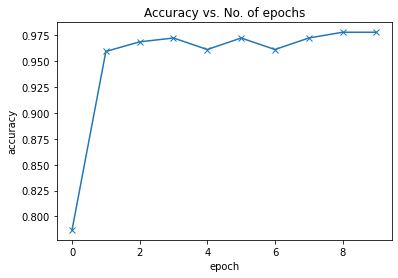

In [42]:
plot_accuracies(history)


In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

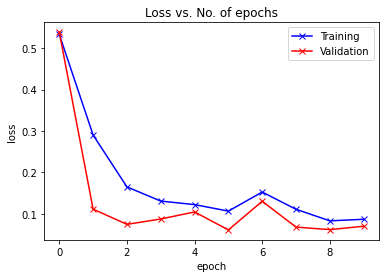

In [44]:
plot_losses(history)

# Testing the model


In [45]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [46]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img, label = test_dataset[75]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [54]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.739062488079071, 'val_loss': 1.2300368547439575}

In [55]:
model2 = to_device(PneumoniaCNN(), device)

In [57]:
evaluate(model2, test_loader)


{'val_acc': 0.6343749761581421, 'val_loss': 0.6910778284072876}